In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt #we will need matplotlib for visualisation
import numpy as np #we will need numpy arrays for our data
import pandas as pd
import seaborn as sns
import os
import tkinter as tk
from tkinter import filedialog
import numpy as np
from PIL import Image, ImageTk
import joblib
from skimage.io import imread
from skimage.transform import resize
from collections import Counter
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage

import pprint #import pprint to make some output look nicer
pp = pprint.PrettyPrinter(indent=4)


In [2]:
def resize_all(src, pickle_filename=None, width=200, height=200):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pickle_filename}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pickle_filename: str
        path to output file
    width: int
        target width of the image in pixels
    height: int
        target height of the image in pixels
    include: set[str]
        set containing str
    """
     
    data = dict()
    data['description'] = 'resized ({0}x{1})x-ray images'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pickle_filename = f"{pickle_filename}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        current_path = os.path.join(src, subdir)
        for file in os.listdir(current_path):
            if file[-4:] in {'.jpg', '.png','jpeg'}:
                im = imread(os.path.join(current_path, file), as_gray=True)
                im = resize(im, (width, height))
                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im) 
    joblib.dump(data, pickle_filename)
    
    return data

In [3]:
# path to the x-ray dataset
    
data_path = r".\Pneumonia\chest_xray"

for subdir in os.listdir(data_path):
    print(subdir)

# os.listdir(data_path)


NORMAL
PNEUMONIA


In [4]:
base_name = 'Chest_Xrays'
width=200

data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
# data=resize_all(src=data_path, pickle_filename=base_name,width=width,height=width)

In [5]:
pd.DataFrame(data)

,description,label,filename,data
0,resized (200x200)x-ray images,NORMAL,NORMAL-1003233-0001.jpg,"[[0.36512229686588704, 0.37799100376793854, 0...."
1,resized (200x200)x-ray images,NORMAL,NORMAL-1012843-0001.jpg,"[[0.5708126637829931, 0.5752581059306772, 0.57..."
2,resized (200x200)x-ray images,NORMAL,NORMAL-1014768-0001.jpg,"[[0.2656177850200076, 0.2587908047801075, 0.27..."
3,resized (200x200)x-ray images,NORMAL,NORMAL-1023731-0001.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,resized (200x200)x-ray images,NORMAL,NORMAL-1029510-0001.jpg,"[[0.09305528529568367, 0.008801276581264148, 2..."
...,...,...,...,...
5851,resized (200x200)x-ray images,PNEUMONIA,VIRUS-9947411-0002.jpg,"[[0.0903613607301179, 0.3695468277479651, 0.77..."
5852,resized (200x200)x-ray images,PNEUMONIA,VIRUS-9962961-0002.jpg,"[[0.32453338106873053, 0.33079887129816943, 0...."
5853,resized (200x200)x-ray images,PNEUMONIA,VIRUS-9963654-0001.jpg,"[[0.007432436375303767, 0.004504443873505491, ..."
5854,resized (200x200)x-ray images,PNEUMONIA,VIRUS-9968655-0001.jpg,"[[0.031215897784282447, 0.031419567683393636, ..."


In [6]:

 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  5856
keys:  ['description', 'label', 'filename', 'data']
image shape:  (200, 200)
labels: ['NORMAL' 'PNEUMONIA']


Counter({'PNEUMONIA': 4273, 'NORMAL': 1583})

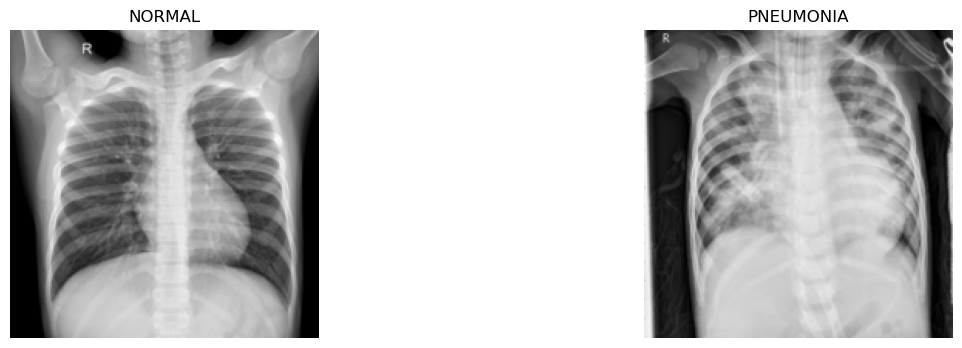

In [7]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
# fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
    ax.imshow(data['data'][idx],cmap='gray')
    ax.axis('off')
    ax.set_title(label)

In [8]:
# we name the input data X and result (labels) y.

X = np.array(data['data'])
y = np.array(data['label'])

# We split and shuffle the data in an evenly manner so that all classes are represented when training
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.10, 
    shuffle=True,
    stratify=y,
    random_state=42,
)

number of train samples:  5270
number of test samples:  586
train labels: Counter({'PNEUMONIA': 3845, 'NORMAL': 1425})
test labels: Counter({'PNEUMONIA': 428, 'NORMAL': 158})


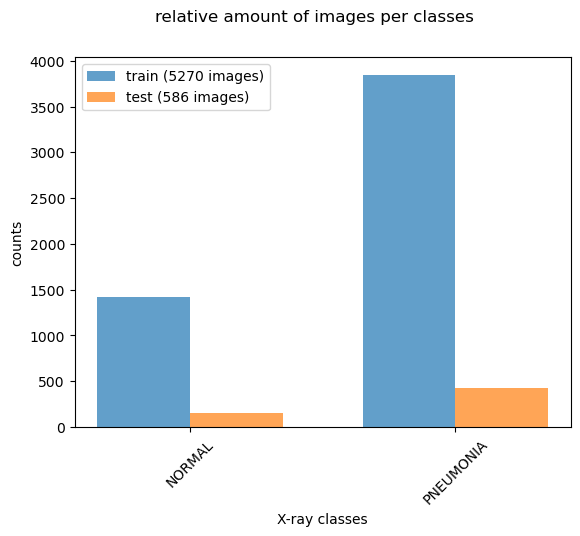

In [9]:
# To verify that the distribution of photos in the training and test set is similar, 
# let’s look at the relative number of images per category.
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
    counts = counts[sorted_index]
    
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('X-ray classes')
    plt.ylabel('counts')
 
print('number of train samples: ', len(y_train))
print('number of test samples: ', len(y_test))
print('train labels:', Counter(y_train))
print('test labels:', Counter(y_test))

plt.suptitle('relative amount of images per classes')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')    
plt.legend([
    'train ({0} images)'.format(len(y_train)), 
    'test ({0} images)'.format(len(y_test))]);

### Preprocessing
A classic approach to object recognition is HOG-SVM, which stands for Histogram of Oriented Gradients and Support Vector Machines.<br>HOGs are used for feature reduction, in other words: for lowering the complexity of the problem, while maintaining as much variation as possible.</br>To calculate a HOG, an image is divided into blocks, for example 8 by 8 pixels. For each of these blocks, the magnitude of the gradient in a given number of directions is calculated.<br>
For a detailed explanation, we refer to http://www.learnopencv.com/histogram-of-oriented-gradients/.</br>

### Transformers

When calculating our HOG, we performed a transformation. We can transform our entire data set using transformers. These are objects that take in the array of data, transform each item and return the resulting data.
<p>Here, we need to convert colour images to grayscale, calculate their HOGs and finally scale the data. For this, we use three transformers in a row: RGB2GrayTransformer, HOGTransformer and StandardScaler. The final result is an array with a HOG for every image in the input.</p>
Scikit-learn comes with many built-in transformers, such as a StandardScaler to scale features and a Binarizer to map string features to numerical features. In addition, it provides the BaseEstimator and TransformerMixin classes to facilitate making your own Transformers.
<p>A custom transformer can be made by inheriting from these two classes and implementing an __init__, fit and transform method. The TransformerMixin class provides the fit_transform method, which combines the fit and transform that we implemented.</p>

In [10]:

     
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=8,
                 pixels_per_cell=(16, 16),
                 cells_per_block=(2, 2)):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [11]:
# create an instance of each transformer
hogify = HogTransformer()
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(5270, 3872)


In [22]:
X_train_prepared

array([[ 0.26217755,  0.86908603,  1.64477835, ..., -0.36887317,
        -0.18886436,  0.74122395],
       [-1.36340843, -0.62751828, -0.47491826, ..., -0.58859081,
        -0.65133877,  0.73618204],
       [ 0.13849284, -0.64379857, -0.39892346, ...,  2.88433197,
         2.76224317,  0.52240682],
       ...,
       [ 1.11450982, -0.98303924, -0.98507408, ..., -0.58859081,
        -0.7793825 , -0.79434282],
       [-0.90544678, -1.07303904, -0.87781049, ...,  0.18481526,
        -0.78352656,  0.39611398],
       [ 0.89432908,  0.5310788 , -0.66066105, ..., -0.17867648,
        -0.49349471,  0.54081614]])

### SMOTE

In [12]:
print('Count before SMOTE\n',dict((x,list(y_train).count(x)) for x in set(list(y_train))))

smt=SMOTE()
x_sm,y_sm=smt.fit_resample(X_train_prepared,y_train)


print('Count after SMOTE\n',dict((x,list(y_sm).count(x)) for x in set(list(y_sm))))

Count before SMOTE
 {'PNEUMONIA': 3845, 'NORMAL': 1425}
Count after SMOTE
 {'PNEUMONIA': 3845, 'NORMAL': 3845}


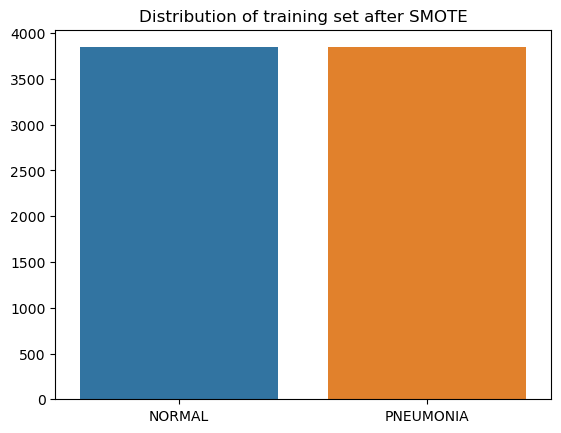

In [32]:
plt.title('Distribution of training set after SMOTE')
unique, counts = np.unique(y_sm, return_counts=True)
sns.barplot(y=counts,x=unique)
plt.show()

### Training

The next step is to train a classifier. We will start with Multilayer Perceptron (MLP), because it is fast and works reasonably well.

First we create an instance and then we call the fit method passing our training data and labels.

In [13]:
model=MLPClassifier(max_iter = 1000,verbose=True,random_state=42)
Model_MLP=model.fit(x_sm,y_sm)

Iteration 1, loss = 0.18680825
Iteration 2, loss = 0.03891658
Iteration 3, loss = 0.01618512
Iteration 4, loss = 0.00599308
Iteration 5, loss = 0.00292237
Iteration 6, loss = 0.00187739
Iteration 7, loss = 0.00141640
Iteration 8, loss = 0.00113540
Iteration 9, loss = 0.00092129
Iteration 10, loss = 0.00078010
Iteration 11, loss = 0.00067801
Iteration 12, loss = 0.00058529
Iteration 13, loss = 0.00051826
Iteration 14, loss = 0.00046705
Iteration 15, loss = 0.00042074
Iteration 16, loss = 0.00038059
Iteration 17, loss = 0.00034779
Iteration 18, loss = 0.00032155
Iteration 19, loss = 0.00029733
Iteration 20, loss = 0.00027665
Iteration 21, loss = 0.00025871
Iteration 22, loss = 0.00024393
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


### Testing
To test the trained MLP classifier, we will use our test set. First, we transform it using the same transformers as before. 
<br>However, we must take care that our test data will not influence the transformers. Some transformers, like PCA (Principle Component Analysis), can optimise themselves on the data before applying the transformation.</br>
To prevent this, we call transform and not fit_transform on the test data.

In [14]:
# save the model to disk

MultiLayerPerceptron = 'MLPClassifier'

joblib.dump(model,f'{MultiLayerPerceptron}_{width}x{width}px.sav')

# model=joblib.load(f'{MultiLayerPerceptron}_{width}x{width}px.sav')
# load the model from disk
# loaded_model = pickle.load(open(MultiLayerPerceptron, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

['MLPClassifier_200x200px.sav']

In [15]:
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

Model_predict_MLP=model.predict(X_test_prepared)
MLP_class_rpt=classification_report(y_test,Model_predict_MLP,output_dict=True)
MLP_con_mat=confusion_matrix(y_test,Model_predict_MLP)
print(pd.DataFrame(MLP_class_rpt).transpose())
print(f"Train_accuracy: {round(model.score(x_sm,y_sm)*100,2)}")
print(f"Test_accuracy_score: {round(accuracy_score(y_test,Model_predict_MLP)*100,2)}")
print(f"Test_precision_score: {round(precision_score(y_test,Model_predict_MLP,average='weighted')*100,2)}")
print(f"Test_recall_score: {round(recall_score(y_test,Model_predict_MLP,average='weighted')*100,2)}")
print(f"Test_f1_score: {round(f1_score(y_test,Model_predict_MLP,average='weighted')*100,2)}")

              precision    recall  f1-score     support
NORMAL         0.939394  0.981013  0.959752  158.000000
PNEUMONIA      0.992874  0.976636  0.984688  428.000000
accuracy       0.977816  0.977816  0.977816    0.977816
macro avg      0.966134  0.978824  0.972220  586.000000
weighted avg   0.978455  0.977816  0.977965  586.000000
Train_accuracy: 100.0
Test_accuracy_score: 97.78
Test_precision_score: 97.85
Test_recall_score: 97.78
Test_f1_score: 97.8


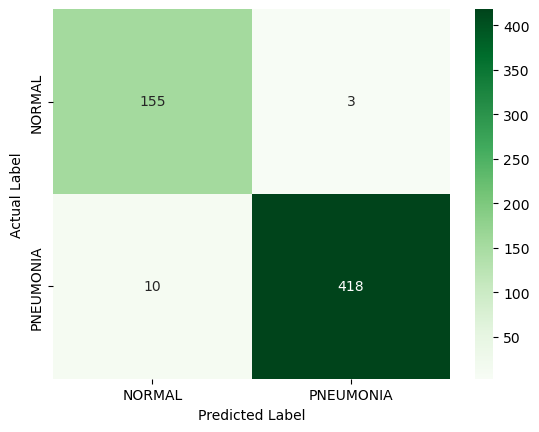

In [16]:
sns.heatmap(MLP_con_mat, cmap="Greens",xticklabels=np.unique(y_test),yticklabels=np.unique(y_test), annot = True,fmt='0')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [17]:
# Create the main application window
app = tk.Tk()
app['bg']='#2a636e'
app.title('PNEUMONIA DIAGNOSTIC SYSTEM')

# Frame to hold the images
image_frame = tk.Frame(app)
image_frame.pack(pady=5)

# Function to open file dialog and get selected files
def open_file_dialog():
    file_paths = filedialog.askopenfilenames(title="Select X-ray images", filetypes=[("Image files", "*.png;*.jpg;*.jpeg")])
    process_images(file_paths)

# Function to process selected images and display prediction results
def process_images(file_paths):
    # Clear existing images and results
    clear_display()

    if not file_paths:
        return

    # Display selected images and prediction results
    display_prediction_results(file_paths)

# Function to clear existing images and results
def clear_display():
    for widget in image_frame.winfo_children():
        widget.destroy()

# Function to preprocess and display selected images along with prediction results
def display_prediction_results(file_paths):
    max_columns = 5
    for idx, file_path in enumerate(file_paths):
        # Preprocess image
        img = Image.open(file_path).convert("L").resize((200, 200))
        img_array = np.array(img)
        img_array_hog = hogify.transform(np.stack([img_array]))
        img_array_prepared = scalify.transform(img_array_hog)

        # Predict using the MLP model
        prediction = model.predict(img_array_prepared)[0]

        # Calculate row and column positions
        row_position = idx // max_columns
        col_position = idx % max_columns

        # Display the image
        img = ImageTk.PhotoImage(Image.fromarray(img_array))
        img_label = tk.Label(image_frame, image=img)
        img_label.grid(row=row_position, column=col_position * 2, padx=5, pady=5, sticky='w')

        # Display the prediction result
        result_label = tk.Label(image_frame, text=prediction)
        result_label.grid(row=row_position, column=col_position * 2 + 1, sticky='w')

        # Keep a reference to the image to prevent it from being garbage collected
        img_label.image = img

# Button to open file dialog
open_button = tk.Button(app, text="Open X-ray Images", command=open_file_dialog)
open_button.pack(pady=5)

# Button to manually clear the screen
clear_button = tk.Button(app, text="Clear Screen", command=clear_display)
clear_button.pack(pady=5)

# Run the Tkinter main loop
app.mainloop()